In [19]:
import requests
import pandas as pd
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
endpoint = "https://data.nashville.gov/resource/2u6v-ujjs.json"

params = {
    '$where' : "incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'",
    'offense_nibrs' : '220',
    #'$q' : 'BURGLARY- AGGRAVATED'
    '$limit' : 5000
}

response = requests.get(endpoint, params = params)

res = response.json()
all_burglary = pd.DataFrame(res)

In [3]:
agg_burglary = all_burglary.loc[
    all_burglary['offense_description'].str.upper().str.contains('AGGRAVATED')
].copy()

agg_burglary['geometry'] = gpd.points_from_xy(
    agg_burglary['longitude'], 
    agg_burglary['latitude']
)

In [4]:
with open('..\census_api.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [5]:
endpoint = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:47&in=county:037&key={api_key}'

response = requests.get(endpoint)

res = response.json()
population = pd.DataFrame(res)

In [6]:
population = (population
 .rename(columns = population.iloc[0])
 .drop(population.index[0])
 .rename(columns={'NAME' : 'name', 'B01001_001E' : 'population'})
)

In [7]:
endpoint = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S1901_C01_012E&for=tract:*&in=state:47&in=county:037&key={api_key}'

response = requests.get(endpoint)

res = response.json()
median_income = pd.DataFrame(res)

In [8]:
median_income = (median_income
 .rename(columns = median_income.iloc[0])
 .drop(median_income.index[0])
 .rename(columns = {'NAME' : 'name', 'S1901_C01_012E' : 'median_income'})
)

In [9]:
census_tract = gpd.read_file('../data/tl_2020_47_tract/tl_2020_47_tract.shp')

In [10]:
agg_burg_geo = gpd.GeoDataFrame(
    agg_burglary, 
    crs = census_tract.crs, 
    geometry = agg_burglary['geometry']
).drop_duplicates(subset = ['incident_number'])

In [11]:
agg_burg_tract = (
    gpd.sjoin(agg_burg_geo, census_tract, how = 'right', predicate = 'within')
).rename(columns = {'TRACTCE' : 'tract'})

agg_burg_tract = agg_burg_tract.merge(
    population, 
    how = 'inner', 
    on = 'tract'
)

agg_burg_tract = agg_burg_tract.merge(
    median_income, 
    how = 'inner', 
    on = 'tract'
)

agg_burg_tract['median_income'] = agg_burg_tract['median_income'].astype('float')

agg_burg_tract = agg_burg_tract.loc[
   agg_burg_tract['median_income'] >= 0
]

agg_burg_tract['population'] = agg_burg_tract['population'].astype('int')

agg_burg_tract = agg_burg_tract.loc[
    agg_burg_tract['population'] != 0
]

Which census tract had the highest number of burglaries?

In [12]:
agg_burg_tract['tract'].value_counts().nlargest(1)

014300    41
Name: tract, dtype: int64

Which census tract had the highest number of burglaries per 1000 residents?

In [27]:
rate = (agg_burg_tract
        .groupby(['tract', 'population','median_income'])
        .count()
        .reset_index()[['tract', 'population', 'median_income', 'incident_number']]
        #.apply(lambda rate: rate['population'] /1000)
       )

rate['rate'] = rate['incident_number'] / (rate['population'] / 1000)

rate.sort_values(
    by = 'rate', 
    ascending = False
).head()

,tract,population,median_income,incident_number,rate
53,014300,1617,40425.0,41,25.355597
96,016300,2689,54886.0,37,13.759762
52,014200,2072,24237.0,27,13.030888
93,016000,2570,21868.0,30,11.673152
36,012600,2152,56667.0,21,9.758364


In [14]:
med_income_burg = (agg_burg_tract.groupby(['tract', 'median_income'])
    .count()
 .reset_index()[['tract', 'median_income', 'incident_number']]
)

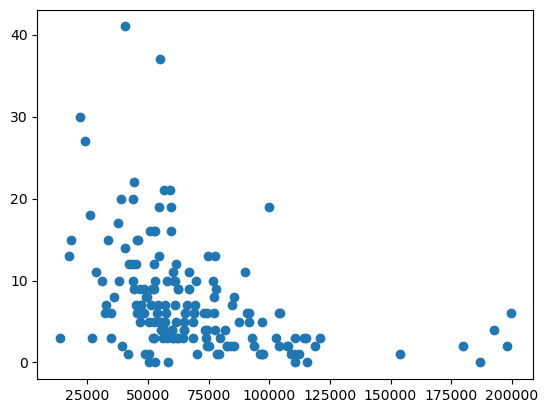

In [15]:
plt.scatter(data = med_income_burg,
        x = 'median_income',
        y = 'incident_number');

In [16]:
summary = (
    med_income_burg
    .assign(group = pd.qcut(med_income_burg['median_income'],
                            q = 10,
                           duplicates = 'drop'))
    .groupby('group')
    [['median_income', 'incident_number']]
    .mean()
    .reset_index()
)


summary

,group,median_income,incident_number
0,"(13749.999, 38951.1]",28729.058824,11.882353
1,"(38951.1, 46749.6]",43338.411765,13.117647
2,"(46749.6, 51028.9]",48479.352941,6.294118
3,"(51028.9, 55249.6]",53071.941176,10.411765
4,"(55249.6, 60072.0]",57604.647059,8.000000
5,"(60072.0, 65577.8]",62374.411765,6.294118
6,"(65577.8, 74996.2]",70782.705882,6.058824
7,"(74996.2, 85752.0]",80240.058824,4.941176
8,"(85752.0, 107205.6]",96926.941176,4.941176
9,"(107205.6, 199643.0]",138605.058824,2.000000


In [22]:
pr_rate_income = smf.glm('rate ~ median_income',
                 data = rate,
                 offset = np.log(rate['population']),
                 family = sm.families.Poisson()
                 ).fit()

pr_rate_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   rate   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -406.31
Date:                Thu, 10 Nov 2022   Deviance:                       424.36
Time:                        19:02:04   Pearson chi2:                 1.02e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4463
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.1272      0.152    -40.194      0.000      -6.426      -5.828
median_income -2.341e-05   2.61e-06     -8.967      0.000   -2.85e-05   -1.83e-05
=================================================================================
"""